# Convolutions for images

First of all, we perform all the necessary imports. In order to ensure reproducibility, we set a constant seed for the random number generator in PyTorch using the `torch.manual_seed()` method.

In some circumstances, when given tensors on a CUDA device and using the CuDNN library, the cross-correlation operator in PyTorch may select a nondeterministic algorithm to increase performance. In order to ensure reproducibility, we can make the operation deterministic (potentially at a performance cost) by setting `torch.backends.cudnn.deterministic = True`.

Because the networks we discuss in this laboratory are rather big, we will need a GPU to train them, so please make sure the GPU hardware accelerator is selected in the *Change runtime type* dialog.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [2]:
!nvidia-smi

Mon Nov 14 18:51:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.48       Driver Version: 517.48       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:06:00.0  On |                  N/A |
|  0%   50C    P0    29W / 125W |   2657MiB /  6144MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The two-dimensional cross-correlation operation is implemented in the `torch.nn.functional.conv2d()` function in PyTorch, which accepts an input tensor `X` and a kernel tensor `K` and returns an output tensor `Y`. The shape of the input tensor is $b\times c_{in}\times n_{h}\times n_{w}$, where $b$ is the batch size, $c_{in}$ is the number of channels in the input, and $n_{h}\times n_{w}$ is the shape of the input images. The shape of the kernel tensor is $c_{out} \times c_{in}\times k_{h}\times k_{w}$, where $c_{in}$ is the number of channels in the input, $c_{out}$ is the number of output channels, and $k_{h}$ and $k_{w}$ are the height and width of the kernel, respectively.

We test this function on the example in the course:

In [3]:
X = torch.tensor([[[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]]]])
K = torch.tensor([[[[0.0, 1.0], [2.0, 3.0]]]])
F.conv2d(X, K)

tensor([[[[19., 25.],
          [37., 43.]]]])

# Padding and stride

Next, we illustrate two-dimensional cross-correlation with padding. We apply $1$ pixel of padding on all sides. We test this on the example in the course:

In [4]:
X = torch.tensor([[[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]]]])
K = torch.tensor([[[[0.0, 1.0], [2.0, 3.0]]]])
F.conv2d(X, K, padding=1)

tensor([[[[ 0.,  3.,  8.,  4.],
          [ 9., 19., 25., 10.],
          [21., 37., 43., 16.],
          [ 6.,  7.,  8.,  0.]]]])

For use as part of a network, PyTorch also has the `nn.Conv2d` layer. The first two parameters of the `nn.Conv2d` layer represent the number of input channels and the number of output channels, respectively. In the following example, we create a two-dimensional convolutional layer with a height and width of $3$ (specified by the `kernel_size` parameter), and apply $1$ pixel of padding on all sides (specified by the `padding` parameter). Given an input with a height and width of $8$, we find that the height and width of the output is also $8$.

In [5]:
X = torch.rand(1, 1, 8, 8)
# Note that here 1 row or column is padded on either side, so a total of 2
# rows or columns are added
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
conv2d(X).shape

torch.Size([1, 1, 8, 8])

When the height and width of the convolution kernel are different, we can make the output and input have the same height and width by setting different padding numbers for height and width.

In [6]:
# Here, we use a convolution kernel with a height of 5 and a width of 3. The
# padding numbers on either side of the height and width are 2 and 1,
# respectively
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
conv2d(X).shape

torch.Size([1, 1, 8, 8])

Cross-correlation with strides of $3$ and $2$ for height and width, respectively (specified using the `stride` parameter), can also be illustrated using the example in the course:

In [7]:
X = torch.tensor([[[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]]]])
K = torch.tensor([[[[0.0, 1.0], [2.0, 3.0]]]])
F.conv2d(X, K, padding=1, stride=(3, 2))

tensor([[[[0., 8.],
          [6., 8.]]]])

Given an input with a height and width of $8$, below, we set the strides on both the height and width to $2$, thus halving the input height and width.

In [8]:
X = torch.rand(1, 1, 8, 8)
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
conv2d(X).shape

torch.Size([1, 1, 4, 4])

Next, we will look at a slightly more complicated example.

In [9]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
conv2d(X).shape

torch.Size([1, 1, 2, 2])

#Multiple input and multiple output channels

We next illustrate the cross-correlation operation with $2$ input channels, i.e., $c_{in}=2$. The example in the course is now:

In [10]:
X = torch.tensor([[[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]]])
K = torch.tensor([[[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]]])
F.conv2d(X, K)

tensor([[[[ 56.,  72.],
          [104., 120.]]]])

In order to illustrate multiple output channels, we construct a convolution kernel with $3$ output channels by concatenating the kernel tensor `K` with `K+1` (plus one for each element in `K`) and `K+2`.

In [11]:
K = torch.cat((K, K + 1, K + 2))
K.shape

torch.Size([3, 2, 2, 2])

Below, we perform cross-correlation operations on the input tensor `X` with the kernel tensor `K`. Now, the output contains $3$ channels. The result of the first channel is consistent with the result of the previous input tensor `X` and the multi-input channel, single-output channel kernel.

In [12]:
F.conv2d(X, K)

tensor([[[[ 56.,  72.],
          [104., 120.]],

         [[ 76., 100.],
          [148., 172.]],

         [[ 96., 128.],
          [192., 224.]]]])

# Pooling

The maximum pooling and average pooling operations are implemented in PyTorch in the `torch.nn.functional.max_pool2d()` and `torch.nn.functional.avg_pool2d()` functions, respectively. The shape of the input tensor `X` is similar to the one for the `torch.nn.functional.conv2d()` function. By default, the `stride` parameter is set to be equal to `kernel_size`, so, if we want to reproduce the example in the course, we must set `kernel_size=2` and `stride=1` as parameters:

In [13]:
X = torch.tensor([[[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]]]])
F.max_pool2d(X, kernel_size=2, stride=1)

tensor([[[[4., 5.],
          [7., 8.]]]])

Also, we experiment with the average pooling operation.

In [14]:
F.avg_pool2d(X, kernel_size=2, stride=1)

tensor([[[[2., 3.],
          [5., 6.]]]])

We can demonstrate the use of padding and strides in pooling layers via the built-in two-dimensional maximum pooling layer from PyTorch, i.e., the `nn.MaxPool2d` layer. We first construct an input tensor `X` whose shape has four dimensions, where the number of examples (batch size) and number of channels are both $1$.

In [15]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

Again, by default, the stride and the pooling window in the `nn.MaxPool2d` class have the same shape. Below, we use a pooling window of shape $3\times 3$, so we get a stride shape of $3\times 3$, by default.

In [16]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

The stride and padding can also be manually specified.

In [17]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

Of course, we can specify an arbitrary rectangular pooling window and specify the padding and stride for height and width, respectively.

In [18]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

When processing multi-channel input data, the pooling layer pools each input channel separately, rather than summing the inputs over channels, as in a convolutional layer. This means that the number of output channels for the pooling layer is the same as the number of input channels. Below, we concatenate tensors `X` and `X + 1` on the channel dimension to construct an input with $2$ channels.

In [19]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

As we can see, the number of output channels is still $2$ after pooling.

In [20]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

# Convolutional neural networks (LeNet)

While getting to the point where we truly understand what is going on inside LeNet may have taken a bit of work, hopefully the following code snippet will convince us that implementing such models with modern deep learning frameworks is remarkably simple. We need only to instantiate a `nn.Sequential` block and chain together the appropriate layers. Note the use of the `nn.Flatten` layer to reshape the 4D tensors processed by convolutional and pooling layers into 2D tensors, the only type a linear (fully-connected) layer can process.

In [21]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

By passing a single-channel (black and white) $28\times 28$ image through the network and printing the output shape at each layer, we can inspect the model to make sure that its operations line up with what we expect. 

In [22]:
X = torch.rand(1, 1, 28, 28)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


Note that the height and width of the representation at each layer throughout the convolutional block is reduced (compared with the previous layer). The first convolutional layer uses $2$ pixels of padding to compensate for the reduction in height and width that would otherwise result from using a $5\times 5$ kernel. In contrast, the second convolutional layer doesn't use padding, and thus the height and width are both reduced by $4$ pixels. As we go up the stack of layers, the number of channels increases layer-over-layer from $1$ in the input to $6$ after the first convolutional layer and $16$ after the second convolutional layer. However, each pooling layer halves the height and width. Finally, each fully-connected layer reduces dimensionality, finally emitting an output whose dimension matches the number of classes.

Now that we have implemented the model, let us run an experiment to see how LeNet performs on Fashion-MNIST.

In [23]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000],
                                                           generator=torch.Generator().manual_seed(42))
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_val, batch_size, shuffle=False,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

While CNNs have fewer parameters, they can still be more expensive to compute than similarly deep MLPs, because each parameter participates in many more multiplications. That is why we need a GPU to speed up training.

For evaluation, we need to make a slight modification to the `evaluate_accuracy()` function that we described in *Laboratory 8*. Since the full dataset is in the main memory, we need to copy it to the GPU memory, before the model uses GPU to perform computations on the dataset.

In [24]:
def evaluate_accuracy(net, data_iter, loss, device):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100

We also need to update our training function to deal with GPUs. Unlike the `train_epoch()` function defined in *Laboratory 8*, we now need to move each mini-batch of data to our designated device (hopefully, the GPU) prior to making the forward and backward propagations.

In [25]:
def train_epoch(net, train_iter, loss, optimizer, device):  
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training correct predictions, no. of examples
    total_loss = 0
    total_hits = 0
    total_samples = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += float(l)
        total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
        total_samples += y.numel()
    # Return training loss and training accuracy
    return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100

The training function `train()` is also similar to `train()` defined in *Laboratory 8*. Since we will be implementing networks with many layers going forward, we will rely primarily on high-level APIs. The following training function assumes a model created from high-level APIs as input, and is optimized accordingly. We initialize the model parameters on the device indicated by the `device` argument, using Xavier initialization. Just as with MLPs, our loss function is cross-entropy, and we minimize it via mini-batch stochastic gradient descent. We also evaluate the performance of our model on the test set.

In [26]:
def train(net, train_iter, val_iter, test_iter, num_epochs, lr, device):
    """Train a model."""
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('Training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer, device)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter, loss, device)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')
    test_loss, test_acc = evaluate_accuracy(net, test_iter, loss, device)
    print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

The `try_gpu()`, `plot_loss()`, and `plot_accuracy()` functions are the same as in *Laboratory 8*.

In [27]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [28]:
def plot_loss(train_loss_all, val_loss_all):
    epochs = range(1, len(train_loss_all) + 1) 
    plt.plot(epochs, train_loss_all, 'bo', label='Training loss') 
    plt.plot(epochs, val_loss_all, 'b', label='Validation loss') 
    plt.title('Training and validation loss') 
    plt.xlabel('Epochs') 
    plt.ylabel('Loss') 
    plt.legend()  
    plt.show()

In [29]:
def plot_accuracy(train_acc_all, val_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_all, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs') 
    plt.ylabel('Accuracy') 
    plt.legend()
    plt.show()

Now let us train and evaluate the LeNet-5 model, and plot the training and validation losses and accuracies.

In [30]:
batch_size, lr, num_epochs = 256, 0.9, 10
train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size)
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, test_iter, num_epochs, lr, try_gpu()) #2 min

Training on cpu
Epoch 1, Train loss 2.29, Train accuracy 12.39, Validation loss 1.88, Validation accuracy 34.41
Epoch 2, Train loss 1.20, Train accuracy 52.13, Validation loss 1.00, Validation accuracy 57.51
Epoch 3, Train loss 0.88, Train accuracy 64.76, Validation loss 0.83, Validation accuracy 67.48
Epoch 4, Train loss 0.76, Train accuracy 70.42, Validation loss 0.75, Validation accuracy 68.36
Epoch 5, Train loss 0.67, Train accuracy 73.76, Validation loss 0.66, Validation accuracy 75.54
Epoch 6, Train loss 0.62, Train accuracy 75.45, Validation loss 0.63, Validation accuracy 75.74
Epoch 7, Train loss 0.58, Train accuracy 77.38, Validation loss 0.56, Validation accuracy 77.74
Epoch 8, Train loss 0.54, Train accuracy 78.91, Validation loss 0.55, Validation accuracy 79.00
Epoch 9, Train loss 0.52, Train accuracy 79.82, Validation loss 0.55, Validation accuracy 78.99
Epoch 10, Train loss 0.49, Train accuracy 81.38, Validation loss 0.49, Validation accuracy 81.92
Test loss 0.50, Test ac

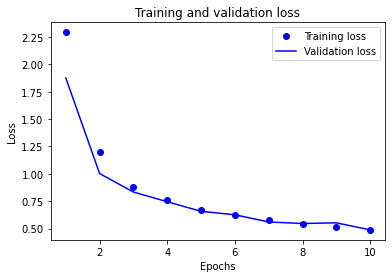

In [31]:
plot_loss(train_loss_all, val_loss_all)